<a href="https://colab.research.google.com/github/spatank/Curiosity/blob/master/v8/PH_plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Curiosity_v8/')

Mounted at /content/drive


In [2]:
!ls # run !ls to verify location

build_Wiki_networks.ipynb	persistent_homology_simulations.ipynb
C_plotting.ipynb		persistent_homology_Wiki.ipynb
Figures				PH_plotting.ipynb
KNOT				Simulations
mech_plotting.ipynb		Wiki
persistent_homology_KNOT.ipynb


In [3]:
import glob
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def plot_barcode(bars, length, dims = [0, 1, 2], end = True):
    """
    Takes in bars, as generated by, e.g., ripser, and plots the barcode.
    """
    bars = dict(bars)
    count = 1
    has_inf = False
    colors = ['xkcd:emerald green', 'xkcd:tealish', 'xkcd:peacock blue']
    # colors = ['#1b9e77','#d95f02','#7570b3']
    # iterate through dimension
    for d in dims:
        bn = bars[d]
        bn = sorted(bn, key = lambda x: x[0])
        for b, i in zip(bn, range(len(bn))):
            # extend in the case of infinite cycles
            if b[1] == np.inf:
                has_inf = True
                b = (b[0], 1.3*length)
            # plot first one with label
            if i == 0:
                plt.plot(b, [count, count], color = colors[d],
                         label='{}-cycles'.format(d))
            else:
                plt.plot(b, [count, count], color = colors[d])
            count += 1
        count += 1
    # add end of filtration line
    plt.axvline(x = length, color = 'xkcd:grey', alpha = 0.5, linestyle = ':')
    if end:
        plt.annotate('Filtration End', (length + 10, 0.5 * count), rotation = 270,
                     color = 'xkcd:grey', alpha = 0.5)
    lims = plt.xlim()
    plt.xlim([-0.05 * length, length * 1.05])
    plt.xlabel('Nodes')
    plt.ylabel('Cycle Number')

def betti_curves(bars, length):
    """
    Takes in bars and returns the betti curves
    """
    bettis = np.zeros((len(bars), length))
    for i in range(bettis.shape[0]):
        bn = bars[i][1]
        for bar in bn:
            birth = int(bar[0])
            death = length+1 if np.isinf(bar[1]) else int(bar[1]+1)
            bettis[i][birth:death] += 1
    return bettis

In [5]:
import sys
!{sys.executable} -m pip install traces

import traces

def time_normalize_and_merge(timeseries_lst, make_1_1 = False):
    """
    Takes in a list of time series (of possibly different lengths) and
    subsamples them using traces so they all range from 0 and 1 and are defined
    on the same points.
    """
    n_series = len(timeseries_lst)
    timeseries_lst = [traces.TimeSeries(zip(*(np.linspace(0, 1, len(ts)), ts)))
                      for ts in timeseries_lst]
    timeseries_lst = traces.TimeSeries.merge(timeseries_lst)
    if make_1_1:
        timeseries_lst[1.0] = [1.0] * n_series
    X = list(zip(*timeseries_lst.items()))[0]  # x values
    Y = list(zip(*timeseries_lst.items()))[1]  # y values across all series
    return X, Y

def plot_curve(curves_lst, curve_label = 'none', curve_color = 'none'):
  """
  Accepts a list of curves and the identity of the null model used if the data 
  come from one; curve_label and curve_color arguments are used for plotting.
  Plots average curve with a standard deviation/error band. 
  """
  
  max_nodes = max([len(lst) for lst in curves_lst])
  curves_mat = np.empty([len(curves_lst), max_nodes])
  curves_mat[:] = np.nan
  for i, j in enumerate(curves_lst):
    curves_mat[i][0:len(j)] = j
  numels = np.count_nonzero(~np.isnan(curves_mat), axis = 0)
  mean = np.nanmean(curves_mat, axis = 0)[numels != 1]
  std = np.nanstd(curves_mat, axis = 0)[numels != 1]
  # mins = mean - std
  mins = mean - np.divide(std, np.sqrt(numels[numels != 1]))
  mins = np.maximum(0, mins)
  # maxes = mean + std
  maxes = mean + np.divide(std, np.sqrt(numels[numels != 1]))
  X = np.arange(len(numels[numels != 1]))

  plt.plot(X, mean, color = curve_color, label = curve_label,
            linewidth = 1)
  plt.fill_between(X, mins, maxes, facecolor = curve_color, alpha = 0.2)


def plot_curve_normalized_idx(curves_lst, curve_label = 'none', curve_color = 'none'):
  """
  Accepts a list of curves and the identity of the null model used if the data 
  come from one; curve_label and curve_color arguments are used for plotting.
  Plots average curve with a standard deviation/error band, and with the x-axis 
  normalized to be [0, 1].
  """
  
  X, Y = time_normalize_and_merge(curves_lst)
  mean = np.nanmean(Y, axis = 1)
  # mins = np.nanmean(Y, axis = 1) - np.nanstd(Y, axis = 1)
  mins = np.nanmean(Y, axis = 1) - np.nanstd(Y, axis = 1)/np.sqrt(len(curves_lst))
  mins = np.maximum(0, mins)
  # maxes = np.nanmean(Y, axis = 1) + np.nanstd(Y, axis = 1)
  maxes = np.nanmean(Y, axis = 1) + np.nanstd(Y, axis = 1)/np.sqrt(len(curves_lst))

  plt.plot(X, mean, color = curve_color, label = curve_label,
            linewidth = 1)
  plt.fill_between(X, mins, maxes, facecolor = curve_color, alpha = 0.2)

  Created wheel for infinity: filename=infinity-1.5-py3-none-any.whl size=3095 sha256=a45bc64fcd678fe799da8c63f366e727c037667fcb5aecc0e919fe2c26399fc4
  Stored in directory: /root/.cache/pip/wheels/ee/2c/f4/26985d995b1d5930ab73914f76ffccd54b1af31c2e68b507bc
Successfully built infinity


# KNOT 

In [6]:
base_path = '/content/drive/My Drive/Curiosity_v8/KNOT/Processed/PH_Python/'

In [7]:
files = glob.glob(base_path + '*.npy')

## All Participants 

In [8]:
all_num_nodes = []
all_bettis_0_orig = []
all_bettis_1_orig = []
all_bettis_2_orig = []
all_bettis_0_edges_rewired = []
all_bettis_1_edges_rewired = []
all_bettis_2_edges_rewired = []
all_bettis_0_latticized = []
all_bettis_1_latticized = []
all_bettis_2_latticized = []

for idx, PH_file in enumerate(files):
  data = np.load(PH_file, allow_pickle = True)
  data_dict = data.item()
  num_nodes = data_dict['num_nodes']
  all_num_nodes.append(num_nodes)
  # bars_orig = data_dict['bars_orig']
  bettis_orig = data_dict['bettis_orig']
  all_bettis_0_orig.append(bettis_orig[0])
  all_bettis_1_orig.append(bettis_orig[1])
  all_bettis_2_orig.append(bettis_orig[2])
  bettis_0_edges_rewired = data_dict['bettis_0_edges_rewired']
  all_bettis_0_edges_rewired.append(list(np.mean(np.array(bettis_0_edges_rewired), axis = 0)))
  bettis_1_edges_rewired = data_dict['bettis_1_edges_rewired']
  all_bettis_1_edges_rewired.append(list(np.mean(np.array(bettis_1_edges_rewired), axis = 0)))
  bettis_2_edges_rewired = data_dict['bettis_2_edges_rewired']
  all_bettis_2_edges_rewired.append(list(np.mean(np.array(bettis_2_edges_rewired), axis = 0)))
  bettis_0_latticized = data_dict['bettis_0_latticized']
  all_bettis_0_latticized.append(list(np.mean(np.array(bettis_0_latticized), axis = 0)))
  bettis_1_latticized = data_dict['bettis_1_latticized']
  all_bettis_1_latticized.append(list(np.mean(np.array(bettis_1_latticized), axis = 0)))
  bettis_2_latticized = data_dict['bettis_2_latticized']
  all_bettis_2_latticized.append(list(np.mean(np.array(bettis_2_latticized), axis = 0)))

In a Betti curve derived from a node-filtered order complex, the x-axis is usually comprised of node indices corresponding to the order in which nodes are added to the growing graph. However, people build networks of different sizes as demonstrated in the histogram below. 

Text(0, 0.5, 'Participants')

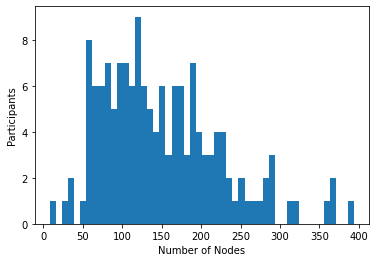

In [9]:
plt.hist(all_num_nodes, density = False, bins = 50)  
plt.xlabel('Number of Nodes')
plt.ylabel('Participants')

We can normalize the x-axis so that the filtration index for all participants ranges between 0 and 1. Thus, we can align values across all sub-sampled Betti curves before taking averages and plotting them. We plot these index normalized plots next to the unprocessed ones.

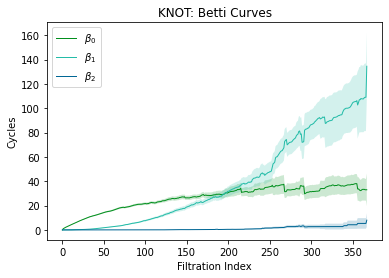

In [10]:
plot_curve(all_bettis_0_orig, curve_label = '$\\beta_{}$'.format(0), curve_color = 'xkcd:emerald green')
plot_curve(all_bettis_1_orig, curve_label = '$\\beta_{}$'.format(1), curve_color = 'xkcd:tealish')
plot_curve(all_bettis_2_orig, curve_label = '$\\beta_{}$'.format(2), curve_color = 'xkcd:peacock blue')
plt.title('KNOT: Betti Curves')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'upper left')
plt.savefig('Figures/PH/all_KNOT_Bettis.pdf', transparent = True, bbox_inches = 'tight')

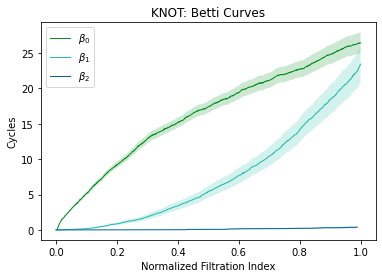

In [11]:
plot_curve_normalized_idx(all_bettis_0_orig, curve_label = '$\\beta_{}$'.format(0), curve_color = 'xkcd:emerald green')
plot_curve_normalized_idx(all_bettis_1_orig, curve_label = '$\\beta_{}$'.format(1), curve_color = 'xkcd:tealish')
plot_curve_normalized_idx(all_bettis_2_orig, curve_label = '$\\beta_{}$'.format(2), curve_color = 'xkcd:peacock blue')
plt.title('KNOT: Betti Curves')
plt.xlabel('Normalized Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'upper left')
plt.savefig('Figures/PH/all_KNOT_Bettis_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

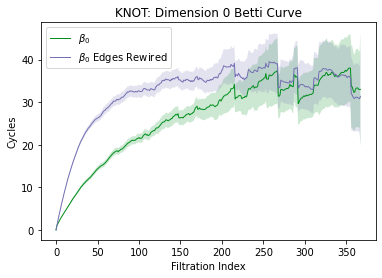

In [12]:
plot_curve(all_bettis_0_orig, curve_label = '$\\beta_{}$'.format(0), curve_color = 'xkcd:emerald green')
plot_curve(all_bettis_0_edges_rewired, curve_label = '$\\beta_{}$ Edges Rewired'.format(0), curve_color = '#7570b3')
# plot_curve(all_bettis_0_latticized, curve_label = '$\\beta_{}$ Latticized'.format(0), curve_color = '#d95f02')
plt.title('KNOT: Dimension 0 Betti Curve')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper left")
plt.savefig('Figures/PH/all_KNOT_Betti_0.pdf', transparent = True, bbox_inches = 'tight')

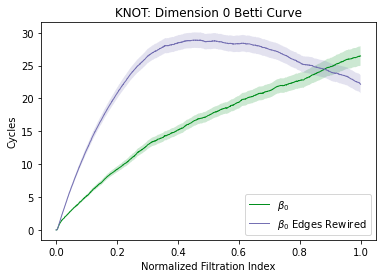

In [13]:
plot_curve_normalized_idx(all_bettis_0_orig, curve_label = '$\\beta_{}$'.format(0), curve_color = 'xkcd:emerald green')
plot_curve_normalized_idx(all_bettis_0_edges_rewired, curve_label = '$\\beta_{}$ Edges Rewired'.format(0), curve_color = '#7570b3')
# plot_curve_normalized_idx(all_bettis_0_latticized, curve_label = '$\\beta_{}$ Latticized'.format(0), curve_color = '#d95f02')
plt.title('KNOT: Dimension 0 Betti Curve')
plt.xlabel('Normalized Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'lower right')
plt.savefig('Figures/PH/all_KNOT_Betti_0_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

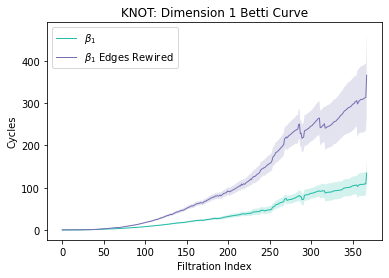

In [14]:
plot_curve(all_bettis_1_orig, curve_label = '$\\beta_{}$'.format(1), curve_color = 'xkcd:tealish')
plot_curve(all_bettis_1_edges_rewired, curve_label = '$\\beta_{}$ Edges Rewired'.format(1), curve_color = '#7570b3')
# plot_curve(all_bettis_1_latticized, curve_label = '$\\beta_{}$ Latticized'.format(1), curve_color = '#d95f02')
plt.title('KNOT: Dimension 1 Betti Curve')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'upper left')
plt.savefig('Figures/PH/all_KNOT_Betti_1.pdf', transparent = True, bbox_inches = 'tight')

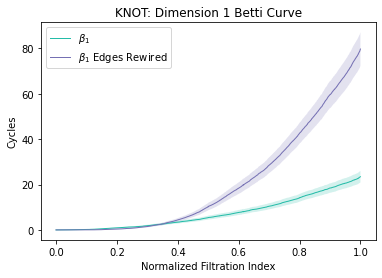

In [15]:
plot_curve_normalized_idx(all_bettis_1_orig, curve_label = '$\\beta_{}$'.format(1), curve_color = 'xkcd:tealish')
plot_curve_normalized_idx(all_bettis_1_edges_rewired, curve_label = '$\\beta_{}$ Edges Rewired'.format(1), curve_color = '#7570b3')
# plot_curve_normalized_idx(all_bettis_1_latticized, curve_label = '$\\beta_{}$ Latticized'.format(1), curve_color = '#d95f02')
plt.title('KNOT: Dimension 1 Betti Curve')
plt.xlabel('Normalized Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'upper left')
plt.savefig('Figures/PH/all_KNOT_Betti_1_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

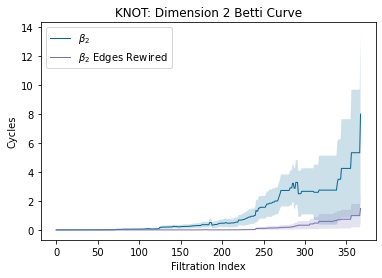

In [16]:
plot_curve(all_bettis_2_orig, curve_label = '$\\beta_{}$'.format(2), curve_color = 'xkcd:peacock blue')
plot_curve(all_bettis_2_edges_rewired, curve_label = '$\\beta_{}$ Edges Rewired'.format(2), curve_color = '#7570b3')
# plot_curve(all_bettis_2_latticized, curve_label = '$\\beta_{}$ Latticized'.format(2), curve_color = '#d95f02')
plt.title('KNOT: Dimension 2 Betti Curve')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'upper left')
plt.savefig('Figures/PH/all_KNOT_Betti_2.pdf', transparent = True, bbox_inches = 'tight')

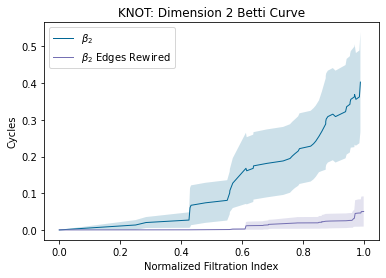

In [17]:
plot_curve_normalized_idx(all_bettis_2_orig, curve_label = '$\\beta_{}$'.format(2), curve_color = 'xkcd:peacock blue')
plot_curve_normalized_idx(all_bettis_2_edges_rewired, curve_label = '$\\beta_{}$ Edges Rewired'.format(2), curve_color = '#7570b3')
# plot_curve_normalized_idx(all_bettis_2_latticized, curve_label = '$\\beta_{}$ Latticized'.format(2), curve_color = '#d95f02')
plt.title('KNOT: Dimension 2 Betti Curve')
plt.xlabel('Normalized Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'upper left')
plt.savefig('Figures/PH/all_KNOT_Betti_2_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

## One Participant

In [18]:
subj_ID = 106
data = np.load(base_path + 'subj_' + str(subj_ID) + '_PH.npy', allow_pickle = True)
data_dict = data.item()

num_nodes = data_dict['num_nodes']
bars_orig = data_dict['bars_orig']
bettis_orig = data_dict['bettis_orig']
bettis_0_edges_rewired = data_dict['bettis_0_edges_rewired']
bettis_1_edges_rewired = data_dict['bettis_1_edges_rewired']
bettis_2_edges_rewired = data_dict['bettis_2_edges_rewired']
bettis_0_latticized = data_dict['bettis_0_latticized']
bettis_1_latticized = data_dict['bettis_1_latticized']
bettis_2_latticized = data_dict['bettis_2_latticized']

X = np.arange(num_nodes)

Text(0.5, 1.0, 'One Participant (KNOT): Barcode')

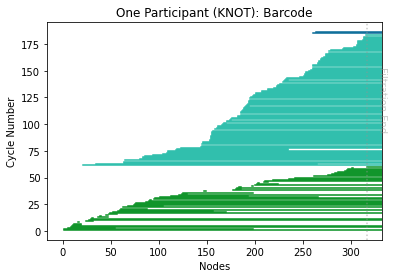

In [19]:
plot_barcode(bars_orig, num_nodes)
plt.title('One Participant (KNOT): Barcode')

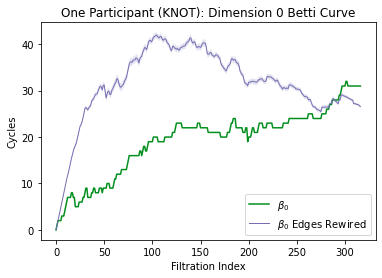

In [20]:
plt.plot(X, bettis_orig[0], color = 'xkcd:emerald green', label = '$\\beta_{}$'.format(0))
plot_curve(bettis_0_edges_rewired, curve_label = '$\\beta_{}$ Edges Rewired'.format(0), curve_color = '#7570b3')
# plot_curve(bettis_0_latticized, curve_label = '$\\beta_{}$ Latticized'.format(0), curve_color = '#d95f02')
plt.title('One Participant (KNOT): Dimension 0 Betti Curve')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "lower right")

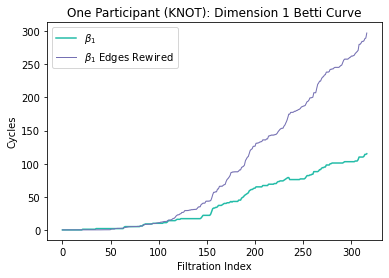

In [21]:
plt.plot(X, bettis_orig[1], color = 'xkcd:tealish', label = '$\\beta_{}$'.format(1))
plot_curve(bettis_1_edges_rewired, curve_label = '$\\beta_{}$ Edges Rewired'.format(1), curve_color = '#7570b3')
# plot_curve(bettis_1_latticized, curve_label = '$\\beta_{}$ Latticized'.format(1), curve_color = '#d95f02')
plt.title('One Participant (KNOT): Dimension 1 Betti Curve')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'upper left')

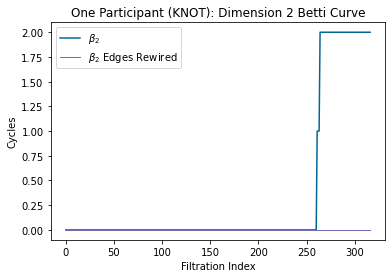

In [22]:
plt.plot(X, bettis_orig[2], color = 'xkcd:peacock blue', label = '$\\beta_{}$'.format(2))
plot_curve(bettis_2_edges_rewired, curve_label = '$\\beta_{}$ Edges Rewired'.format(2), curve_color = '#7570b3')
# plot_curve(bettis_2_latticized, curve_label = '$\\beta_{}$ Latticized'.format(2), curve_color = '#d95f02')
plt.title('One Participant (KNOT): Dimension 2 Betti Curve')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'upper left')

# Wikipedia Networks

In [23]:
base_path = '/content/drive/My Drive/Curiosity_v8/Wiki/Processed/PH_Python/'

In [24]:
files = glob.glob(base_path + '*.npy')

## All Topics

In [25]:
all_num_nodes = []
all_bettis_0_orig = []
all_bettis_1_orig = []
all_bettis_2_orig = []
all_bettis_0_edges_rewired = []
all_bettis_1_edges_rewired = []
all_bettis_2_edges_rewired = []
all_bettis_0_latticized = []
all_bettis_1_latticized = []
all_bettis_2_latticized = []

for idx, PH_file in enumerate(files):
  data = np.load(PH_file, allow_pickle = True)
  data_dict = data.item()
  num_nodes = data_dict['num_nodes']
  all_num_nodes.append(num_nodes)
  # bars_orig = data_dict['bars_orig']
  bettis_orig = data_dict['bettis_orig']
  all_bettis_0_orig.append(bettis_orig[0])
  all_bettis_1_orig.append(bettis_orig[1])
  all_bettis_2_orig.append(bettis_orig[2])
  bettis_0_edges_rewired = data_dict['bettis_0_edges_rewired']
  all_bettis_0_edges_rewired.append(list(np.mean(np.array(bettis_0_edges_rewired), axis = 0)))
  bettis_1_edges_rewired = data_dict['bettis_1_edges_rewired']
  all_bettis_1_edges_rewired.append(list(np.mean(np.array(bettis_1_edges_rewired), axis = 0)))
  bettis_2_edges_rewired = data_dict['bettis_2_edges_rewired']
  all_bettis_2_edges_rewired.append(list(np.mean(np.array(bettis_2_edges_rewired), axis = 0)))
  bettis_0_latticized = data_dict['bettis_0_latticized']
  all_bettis_0_latticized.append(list(np.mean(np.array(bettis_0_latticized), axis = 0)))
  bettis_1_latticized = data_dict['bettis_1_latticized']
  all_bettis_1_latticized.append(list(np.mean(np.array(bettis_1_latticized), axis = 0)))
  bettis_2_latticized = data_dict['bettis_2_latticized']
  all_bettis_2_latticized.append(list(np.mean(np.array(bettis_2_latticized), axis = 0)))

Text(0, 0.5, 'Topics')

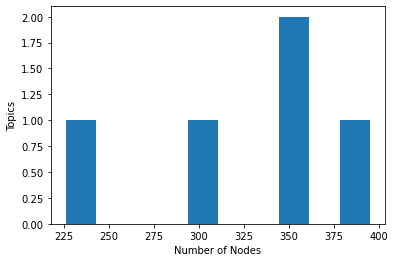

In [26]:
plt.hist(all_num_nodes, density = False)  
plt.xlabel('Number of Nodes')
plt.ylabel('Topics')

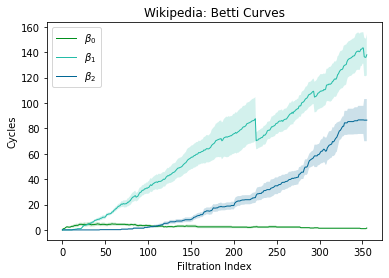

In [27]:
plot_curve(all_bettis_0_orig, curve_label = '$\\beta_{}$'.format(0), curve_color = 'xkcd:emerald green')
plot_curve(all_bettis_1_orig, curve_label = '$\\beta_{}$'.format(1), curve_color = 'xkcd:tealish')
plot_curve(all_bettis_2_orig, curve_label = '$\\beta_{}$'.format(2), curve_color = 'xkcd:peacock blue')
plt.title('Wikipedia: Betti Curves')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'upper left')
plt.savefig('Figures/PH/all_Wiki_Bettis.pdf', transparent = True, bbox_inches = 'tight')

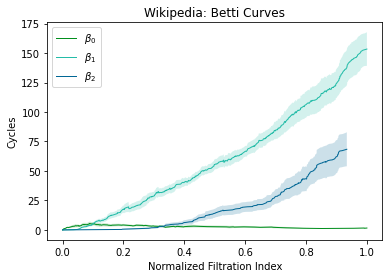

In [28]:
plot_curve_normalized_idx(all_bettis_0_orig, curve_label = '$\\beta_{}$'.format(0), curve_color = 'xkcd:emerald green')
plot_curve_normalized_idx(all_bettis_1_orig, curve_label = '$\\beta_{}$'.format(1), curve_color = 'xkcd:tealish')
plot_curve_normalized_idx(all_bettis_2_orig, curve_label = '$\\beta_{}$'.format(2), curve_color = 'xkcd:peacock blue')
plt.title('Wikipedia: Betti Curves')
plt.xlabel('Normalized Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper left")
plt.savefig('Figures/PH/all_Wiki_Bettis_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

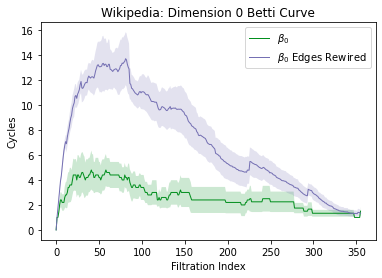

In [29]:
plot_curve(all_bettis_0_orig, curve_label = '$\\beta_{}$'.format(0), curve_color = 'xkcd:emerald green')
plot_curve(all_bettis_0_edges_rewired, curve_label = '$\\beta_{}$ Edges Rewired'.format(0), curve_color = '#7570b3')
# plot_curve(all_bettis_0_latticized, curve_label = '$\\beta_{}$ Latticized'.format(0), curve_color = '#d95f02')
plt.title('Wikipedia: Dimension 0 Betti Curve')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'upper right')
plt.savefig('Figures/PH/all_Wiki_Betti_0.pdf', transparent = True, bbox_inches = 'tight')

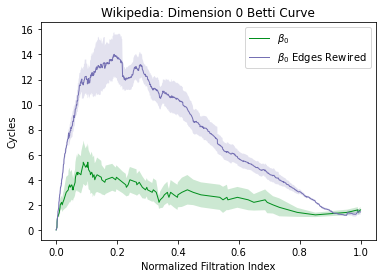

In [30]:
plot_curve_normalized_idx(all_bettis_0_orig, curve_label = '$\\beta_{}$'.format(0), curve_color = 'xkcd:emerald green')
plot_curve_normalized_idx(all_bettis_0_edges_rewired, curve_label = '$\\beta_{}$ Edges Rewired'.format(0), curve_color = '#7570b3')
# plot_curve_normalized_idx(all_bettis_0_latticized, curve_label = '$\\beta_{}$ Latticized'.format(0), curve_color = '#d95f02')
plt.title('Wikipedia: Dimension 0 Betti Curve')
plt.xlabel('Normalized Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'upper right')
plt.savefig('Figures/PH/all_Wiki_Betti_0_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

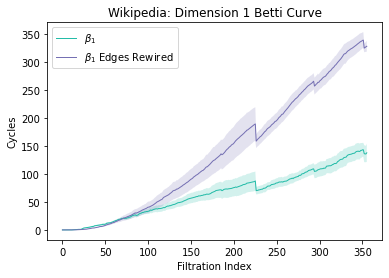

In [31]:
plot_curve(all_bettis_1_orig, curve_label = '$\\beta_{}$'.format(1), curve_color = 'xkcd:tealish')
plot_curve(all_bettis_1_edges_rewired, curve_label = '$\\beta_{}$ Edges Rewired'.format(1), curve_color = '#7570b3')
# plot_curve(all_bettis_1_latticized, curve_label = '$\\beta_{}$ Latticized'.format(1), curve_color = '#d95f02')
plt.title('Wikipedia: Dimension 1 Betti Curve')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'upper left')
plt.savefig('Figures/PH/all_Wiki_Betti_1.pdf', transparent = True, bbox_inches = 'tight')

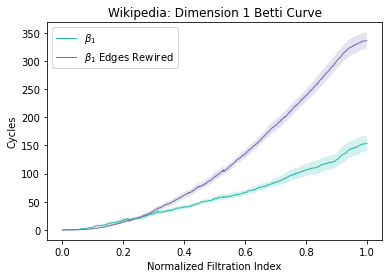

In [32]:
plot_curve_normalized_idx(all_bettis_1_orig, curve_label = '$\\beta_{}$'.format(1), curve_color = 'xkcd:tealish')
plot_curve_normalized_idx(all_bettis_1_edges_rewired, curve_label = '$\\beta_{}$ Edges Rewired'.format(1), curve_color = '#7570b3')
# plot_curve_normalized_idx(all_bettis_1_latticized, curve_label = '$\\beta_{}$ Latticized'.format(1), curve_color = '#d95f02')
plt.title('Wikipedia: Dimension 1 Betti Curve')
plt.xlabel('Normalized Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'upper left')
plt.savefig('Figures/PH/all_Wiki_Betti_1_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

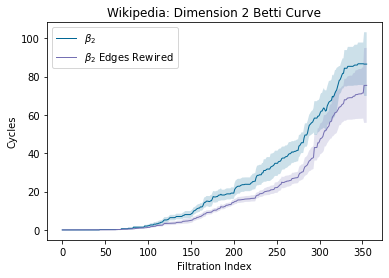

In [33]:
plot_curve(all_bettis_2_orig, curve_label = '$\\beta_{}$'.format(2), curve_color = 'xkcd:peacock blue')
plot_curve(all_bettis_2_edges_rewired, curve_label = '$\\beta_{}$ Edges Rewired'.format(2), curve_color = '#7570b3')
# plot_curve(all_bettis_2_latticized, curve_label = '$\\beta_{}$ Latticized'.format(2), curve_color = '#d95f02')
plt.title('Wikipedia: Dimension 2 Betti Curve')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'upper left')
plt.savefig('Figures/PH/all_Wiki_Betti_2.pdf', transparent = True, bbox_inches = 'tight')

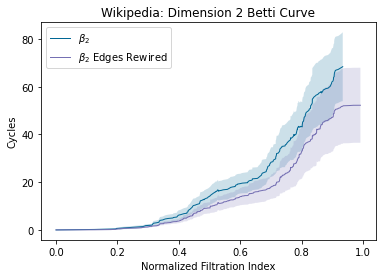

In [34]:
plot_curve_normalized_idx(all_bettis_2_orig, curve_label = '$\\beta_{}$'.format(2), curve_color = 'xkcd:peacock blue')
plot_curve_normalized_idx(all_bettis_2_edges_rewired, curve_label = '$\\beta_{}$ Edges Rewired'.format(2), curve_color = '#7570b3')
# plot_curve_normalized_idx(all_bettis_2_latticized, curve_label = '$\\beta_{}$ Latticized'.format(2), curve_color = '#d95f02')
plt.title('Wikipedia: Dimension 2 Betti Curve')
plt.xlabel('Normalized Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'upper left')
plt.savefig('Figures/PH/all_Wiki_Betti_2_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

## One Topic

In [35]:
topic_ID = 'software_engineering'
data = np.load(base_path + topic_ID + '_PH.npy', allow_pickle = True)
data_dict = data.item()

num_nodes = data_dict['num_nodes']
bars_orig = data_dict['bars_orig']
bettis_orig = data_dict['bettis_orig']
bettis_0_edges_rewired = data_dict['bettis_0_edges_rewired']
bettis_1_edges_rewired = data_dict['bettis_1_edges_rewired']
bettis_2_edges_rewired = data_dict['bettis_2_edges_rewired']
bettis_0_latticized = data_dict['bettis_0_latticized']
bettis_1_latticized = data_dict['bettis_1_latticized']
bettis_2_latticized = data_dict['bettis_2_latticized']

X = np.arange(num_nodes)

Text(0.5, 1.0, 'One Topic (Wikipedia): Barcode')

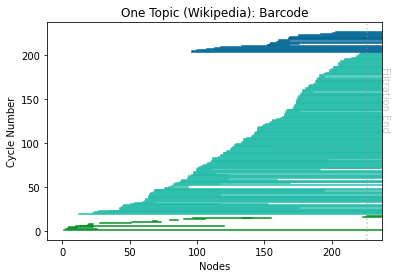

In [36]:
plot_barcode(bars_orig, num_nodes)
plt.title('One Topic (Wikipedia): Barcode')

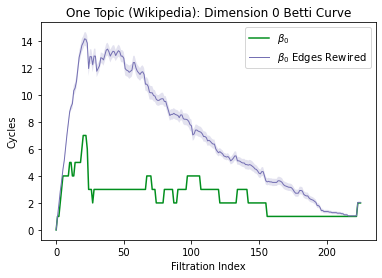

In [37]:
plt.plot(X, bettis_orig[0], color = 'xkcd:emerald green', label = '$\\beta_{}$'.format(0))
plot_curve(bettis_0_edges_rewired, curve_label = '$\\beta_{}$ Edges Rewired'.format(0), curve_color = '#7570b3')
# plot_curve(bettis_0_latticized, curve_label = '$\\beta_{}$ Latticized'.format(0), curve_color = '#d95f02')
plt.title('One Topic (Wikipedia): Dimension 0 Betti Curve')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'upper right')

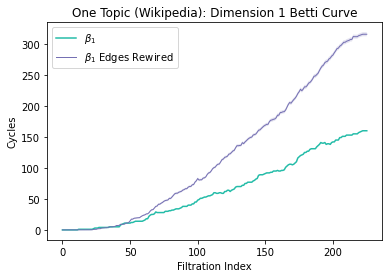

In [38]:
plt.plot(X, bettis_orig[1], color = 'xkcd:tealish', label = '$\\beta_{}$'.format(1))
plot_curve(bettis_1_edges_rewired, curve_label = '$\\beta_{}$ Edges Rewired'.format(1), curve_color = '#7570b3')
# plot_curve(bettis_1_latticized, curve_label = '$\\beta_{}$ Latticized'.format(1), curve_color = '#d95f02')
plt.title('One Topic (Wikipedia): Dimension 1 Betti Curve')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'upper left')

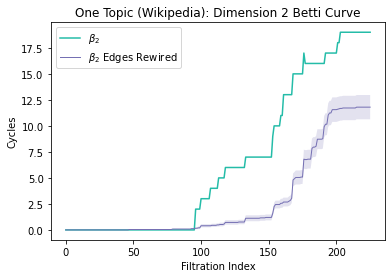

In [39]:
plt.plot(X, bettis_orig[2], color = 'xkcd:tealish', label = '$\\beta_{}$'.format(2))
plot_curve(bettis_2_edges_rewired, curve_label = '$\\beta_{}$ Edges Rewired'.format(2), curve_color = '#7570b3')
# plot_curve(bettis_2_latticized, curve_label = '$\\beta_{}$ Latticized'.format(2), curve_color = '#d95f02')
plt.title('One Topic (Wikipedia): Dimension 2 Betti Curve')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'upper left')

# Simulated Networks

In [40]:
data_path = '/content/drive/My Drive/Curiosity_v8/Simulations/simulated_nets_PH.npy'
data = np.load(data_path, allow_pickle = True)
data_dict = data.item()
num_nodes = data_dict['num_nodes']

## Constant Probability Model

In [41]:
bars_CP = data_dict['bars_CP']
bettis_0_CP = data_dict['bettis_0_CP']
bettis_1_CP = data_dict['bettis_1_CP']
bettis_2_CP = data_dict['bettis_2_CP']

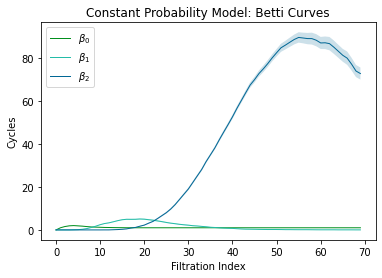

In [42]:
plot_curve(bettis_0_CP, curve_label = '$\\beta_{}$'.format(0), curve_color = 'xkcd:emerald green')
plot_curve(bettis_1_CP, curve_label = '$\\beta_{}$'.format(1), curve_color = 'xkcd:tealish')
plot_curve(bettis_2_CP, curve_label = '$\\beta_{}$'.format(2), curve_color = 'xkcd:peacock blue')
plt.title('Constant Probability Model: Betti Curves')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'upper left')
plt.savefig('Figures/PH/constant_probability_Bettis.pdf', transparent = True, bbox_inches = 'tight')

In [43]:
# plot_curve_normalized_idx(bettis_0_CP, curve_label = '$\\beta_{}$'.format(0), curve_color = 'xkcd:emerald green')
# plot_curve_normalized_idx(bettis_1_CP, curve_label = '$\\beta_{}$'.format(1), curve_color = 'xkcd:tealish')
# plot_curve_normalized_idx(bettis_2_CP, curve_label = '$\\beta_{}$'.format(2), curve_color = 'xkcd:peacock blue')
# plt.title('Constant Probability Model: Betti Curves')
# plt.xlabel('Normalized Filtration Index')
# plt.ylabel('Cycles')
# plt.legend(loc = 'upper left')
# plt.savefig('Figures/PH/constant_probability_Bettis_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

Text(0.5, 1.0, 'Constant Probability Model: Barcode')

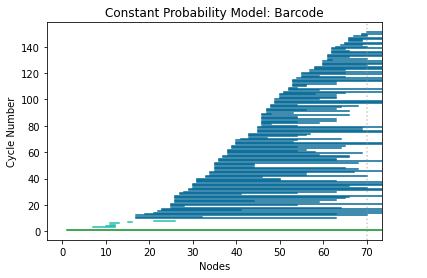

In [44]:
plot_barcode(bars_CP, num_nodes)
plt.title('Constant Probability Model: Barcode')

## Proportional Probability Model

In [45]:
bars_PP = data_dict['bars_PP']
bettis_0_PP = data_dict['bettis_0_PP']
bettis_1_PP = data_dict['bettis_1_PP']
bettis_2_PP = data_dict['bettis_2_PP']

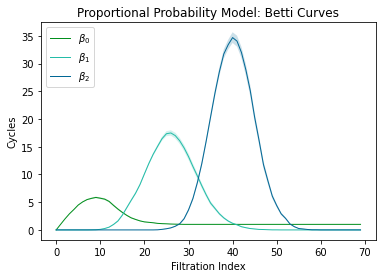

In [46]:
plot_curve(bettis_0_PP, curve_label = '$\\beta_{}$'.format(0), curve_color = 'xkcd:emerald green')
plot_curve(bettis_1_PP, curve_label = '$\\beta_{}$'.format(1), curve_color = 'xkcd:tealish')
plot_curve(bettis_2_PP, curve_label = '$\\beta_{}$'.format(2), curve_color = 'xkcd:peacock blue')
plt.title('Proportional Probability Model: Betti Curves')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'upper left')
plt.savefig('Figures/PH/proportional_probability_Bettis.pdf', transparent = True, bbox_inches = 'tight')

In [47]:
# plot_curve_normalized_idx(bettis_0_PP, curve_label = '$\\beta_{}$'.format(0), curve_color = 'xkcd:emerald green')
# plot_curve_normalized_idx(bettis_1_PP, curve_label = '$\\beta_{}$'.format(1), curve_color = 'xkcd:tealish')
# plot_curve_normalized_idx(bettis_2_PP, curve_label = '$\\beta_{}$'.format(2), curve_color = 'xkcd:peacock blue')
# plt.title('Proportional Probability Model: Betti Curves')
# plt.xlabel('Normalized Filtration Index')
# plt.ylabel('Cycles')
# plt.legend(loc = 'upper left')
# plt.savefig('Figures/PH/proportional_probability_Bettis_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

Text(0.5, 1.0, 'Proportional Probability Model: Barcode')

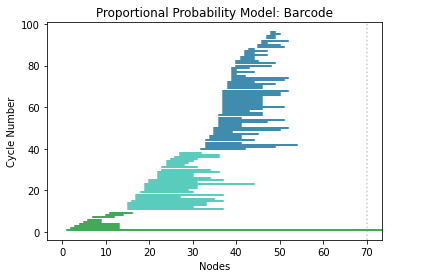

In [48]:
plot_barcode(bars_PP, num_nodes)
plt.title('Proportional Probability Model: Barcode')

## Preferential Attachment Model

In [49]:
bars_PA = data_dict['bars_PA']
bettis_0_PA = data_dict['bettis_0_PA']
bettis_1_PA = data_dict['bettis_1_PA']
bettis_2_PA = data_dict['bettis_2_PA']

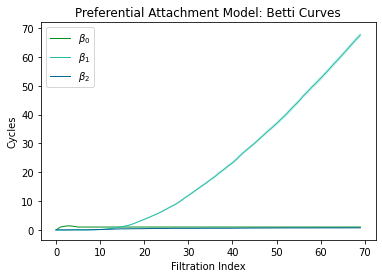

In [50]:
plot_curve(bettis_0_PA, curve_label = '$\\beta_{}$'.format(0), curve_color = 'xkcd:emerald green')
plot_curve(bettis_1_PA, curve_label = '$\\beta_{}$'.format(1), curve_color = 'xkcd:tealish')
plot_curve(bettis_2_PA, curve_label = '$\\beta_{}$'.format(2), curve_color = 'xkcd:peacock blue')
plt.title('Preferential Attachment Model: Betti Curves')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = 'upper left')
plt.savefig('Figures/PH/preferential_attachment_Bettis.pdf', transparent = True, bbox_inches = 'tight')

In [51]:
# plot_curve_normalized_idx(bettis_0_PA, curve_label = '$\\beta_{}$'.format(0), curve_color = 'xkcd:emerald green')
# plot_curve_normalized_idx(bettis_1_PA, curve_label = '$\\beta_{}$'.format(1), curve_color = 'xkcd:tealish')
# plot_curve_normalized_idx(bettis_2_PA, curve_label = '$\\beta_{}$'.format(2), curve_color = 'xkcd:peacock blue')
# plt.title('Preferential Attachment Model: Betti Curves')
# plt.xlabel('Normalized Filtration Index')
# plt.ylabel('Cycles')
# plt.legend(loc = 'upper left')
# plt.savefig('Figures/PH/preferential_attachment_Bettis_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

Text(0.5, 1.0, 'Preferential Attachment Model: Barcode')

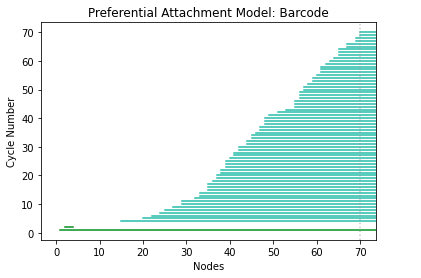

In [52]:
plot_barcode(bars_PA, num_nodes)
plt.title('Preferential Attachment Model: Barcode')